In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from parameters_krycklan import deep_properties
import sys
deepp = deep_properties()

## TESTING LISTS WITH NP.ARRAYS

In [2]:
# Example 2D array size!
'''
shape = (2, 2)
deep_id = np.random.randint(1, 12, size=shape)  # Adjust range based on deep_id count
deep_z = np.random.randint(-30, -20, size=shape)
gridshape = np.ones(shape=deep_id.shape)

# Flattening for processing
deep_id_f = deep_id.flatten()
deep_z_f = deep_z.flatten()

# Function to return NumPy arrays inside a NumPy array
def get_layered_data(deep_id_f, key, deepp, is_pF=False):
    """Returns a NumPy array where each entry is a NumPy array of variable length.
    
    If `is_pF=True`, it skips NumPy conversion (since pF is a dictionary).
    """
    deep_id_map = {v['deep_id']: v[key] if is_pF else np.array(v[key], dtype=float) for v in deepp.values()}
    return np.array([deep_id_map.get(d_id, {} if is_pF else np.array([], dtype=float)) for d_id in deep_id_f], dtype=object)

# Assigning values (NumPy arrays inside NumPy array)
deep_zs = get_layered_data(deep_id_f, 'deep_z', deepp)
deep_ksats = get_layered_data(deep_id_f, 'deep_ksat', deepp)
deep_pFs = get_layered_data(deep_id_f, 'pF', deepp, is_pF=True)  # Do not convert to NumPy array yet

# Handling pF parameters separately, ensuring NumPy arrays
def extract_pF_param(deep_pFs, param):
    """Extracts specific pF parameter and ensures NumPy array conversion."""
    return np.array([np.array(v[param], dtype=float) if isinstance(v, dict) else np.array([], dtype=float) for v in deep_pFs], dtype=object)

deep_ThetaS = extract_pF_param(deep_pFs, 'ThetaS')
deep_ThetaR = extract_pF_param(deep_pFs, 'ThetaR')
deep_n = extract_pF_param(deep_pFs, 'n')
deep_alpha = extract_pF_param(deep_pFs, 'alpha')

print('deep_zs', deep_zs)
print('deep_pFs', deep_pFs)
print('deep_ksats', deep_ksats)
'''

'\nshape = (2, 2)\ndeep_id = np.random.randint(1, 12, size=shape)  # Adjust range based on deep_id count\ndeep_z = np.random.randint(-30, -20, size=shape)\ngridshape = np.ones(shape=deep_id.shape)\n\n# Flattening for processing\ndeep_id_f = deep_id.flatten()\ndeep_z_f = deep_z.flatten()\n\n# Function to return NumPy arrays inside a NumPy array\ndef get_layered_data(deep_id_f, key, deepp, is_pF=False):\n    """Returns a NumPy array where each entry is a NumPy array of variable length.\n    \n    If `is_pF=True`, it skips NumPy conversion (since pF is a dictionary).\n    """\n    deep_id_map = {v[\'deep_id\']: v[key] if is_pF else np.array(v[key], dtype=float) for v in deepp.values()}\n    return np.array([deep_id_map.get(d_id, {} if is_pF else np.array([], dtype=float)) for d_id in deep_id_f], dtype=object)\n\n# Assigning values (NumPy arrays inside NumPy array)\ndeep_zs = get_layered_data(deep_id_f, \'deep_z\', deepp)\ndeep_ksats = get_layered_data(deep_id_f, \'deep_ksat\', deepp)\ndee

## 2D NP.ARRAYS

In [2]:
# INITIALIZING
max_nlyrs = 0
for key, value in deepp.items():
    nlyrs = len(value['deep_z'])
    max_nlyrs = max(max_nlyrs, nlyrs)

# 2D array size!
shape = (400, 400)
deep_id = np.random.randint(1, 2, size=shape)
deep_z = np.random.randint(-30, -20, size=shape)
gridshape = np.ones(shape=deep_id.shape)

# flattening for processing
deep_id_f = deep_id.flatten()
deep_z_f = deep_z.flatten()

# creating the arrays
deep_zs = np.full((len(deep_id_f), max_nlyrs), np.nan)
deep_ksats = np.full((len(deep_id_f), max_nlyrs), np.nan)
deep_pFs = np.empty(len(deep_id_f), dtype=object)
# below if pFs need to separated to each param
#deep_ThetaS = np.full((len(deep_id_f), max_nlyrs), np.nan)
#deep_ThetaR = np.full((len(deep_id_f), max_nlyrs), np.nan)
#deep_n = np.full((len(deep_id_f), max_nlyrs), np.nan)
#deep_alpha = np.full((len(deep_id_f), max_nlyrs), np.nan)
# interpolation functions
deep_ifs = np.empty(shape=[len(deep_id_f)], dtype=object)
deep_ifs_root = np.empty(shape=[len(deep_id_f)], dtype=object)
# each interpolation function separately
wtso_to_gwl = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_wsto = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_C = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_Tr = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_rootmoist = np.empty(shape=[len(deep_id_f)], dtype=object)

# making parametes into 2D arrays (total length and layered information)
for key, value in deepp.items():
    mask = deep_id_f == value['deep_id']
    if np.any(mask):  # Only proceed if at least one match
        nlyrs = len(value['deep_z'])
        deep_zs[mask, :nlyrs] = value['deep_z']
        deep_zs[mask, nlyrs - 1] = deep_z_f[mask]  # Replace last layer
        #deep_ThetaS[mask, :nlyrs] = value['pF']['ThetaS']
        #deep_ThetaR[mask, :nlyrs] = value['pF']['ThetaR']
        #deep_n[mask, :nlyrs] = value['pF']['n']
        #deep_alpha[mask, :nlyrs] = value['pF']['alpha']
        deep_ksats[mask, :nlyrs] = value['deep_ksat']
        deep_pFs[mask] = value['pF']

In [3]:
print('deep_zs', deep_zs)
print('deep_pFs', deep_pFs)
print('deep_ksats', deep_ksats)

deep_zs [[ -1.2  -3.8  -4.   -5.4 -28. ]
 [ -1.2  -3.8  -4.   -5.4 -27. ]
 [ -1.2  -3.8  -4.   -5.4 -24. ]
 ...
 [ -1.2  -3.8  -4.   -5.4 -26. ]
 [ -1.2  -3.8  -4.   -5.4 -29. ]
 [ -1.2  -3.8  -4.   -5.4 -21. ]]
deep_pFs [{'ThetaS': [0.41, 0.41, 0.41, 0.41, 0.41], 'ThetaR': [0.05, 0.05, 0.05, 0.05, 0.05], 'alpha': [0.024, 0.024, 0.024, 0.024, 0.024], 'n': [1.2, 1.2, 1.2, 1.2, 1.2]}
 {'ThetaS': [0.41, 0.41, 0.41, 0.41, 0.41], 'ThetaR': [0.05, 0.05, 0.05, 0.05, 0.05], 'alpha': [0.024, 0.024, 0.024, 0.024, 0.024], 'n': [1.2, 1.2, 1.2, 1.2, 1.2]}
 {'ThetaS': [0.41, 0.41, 0.41, 0.41, 0.41], 'ThetaR': [0.05, 0.05, 0.05, 0.05, 0.05], 'alpha': [0.024, 0.024, 0.024, 0.024, 0.024], 'n': [1.2, 1.2, 1.2, 1.2, 1.2]}
 ...
 {'ThetaS': [0.41, 0.41, 0.41, 0.41, 0.41], 'ThetaR': [0.05, 0.05, 0.05, 0.05, 0.05], 'alpha': [0.024, 0.024, 0.024, 0.024, 0.024], 'n': [1.2, 1.2, 1.2, 1.2, 1.2]}
 {'ThetaS': [0.41, 0.41, 0.41, 0.41, 0.41], 'ThetaR': [0.05, 0.05, 0.05, 0.05, 0.05], 'alpha': [0.024, 0.024, 0.024, 0

## NOW TRYING TO VECTORIZE!

### ATTEMPTING TO VECTORIZE THESE FUNCTIONS BELOW :)

In [3]:
def gwl_Wsto(z, pF, Ksat=None, root=False):
    r""" Forms interpolated function for soil column ground water dpeth, < 0 [m], as a
    function of water storage [m] and vice versa + others

    Args:
        pF (dict of arrays):
            'ThetaS' saturated water content [m\ :sup:`3` m\ :sup:`-3`\ ]
            'ThetaR' residual water content [m\ :sup:`3` m\ :sup:`-3`\ ]
            'alpha' air entry suction [cm\ :sup:`-1`]
            'n' pore size distribution [-]
        dz (np.arrays): soil conpartment thichness, node in center [m]
    Returns:
        (dict):
            'to_gwl': interpolated function for gwl(Wsto)
            'to_wsto': interpolated function for Wsto(gwl)
            'to_C'
            'to_Tr'
    """
    z = np.array(z, dtype=np.float64) # profile depths
    dz = abs(z)
    dz[1:] = z[:-1] - z[1:] # profile depths into profile thicknesses

    # finer grid for calculating wsto to avoid discontinuity in C (dWsto/dGWL)
    step = -0.05
    z_fine= (np.arange(0, min(z), step) + step).astype(np.float64)
    dz_fine = z_fine*0.0 - step
    z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine)

    ix = np.zeros(len(z_fine), dtype=np.float64)

    for depth in z:
        # below makes sure floating point precision doesnt mess with the ix
        ix += np.where((z_fine < depth) & ~np.isclose(z_fine, depth, atol=1e-9), 1, 0)

    pF_fine={}
    for key in pF.keys():
        pp = []
        for i in range(len(z_fine)):
            pp.append(pF[key][int(ix[i])])
        pF_fine.update({key: np.array(pp)})

    # --------- connection between gwl and Wsto, Tr, C------------
    gwl = np.arange(1.0, min(z)-5, step)
    # solve water storage corresponding to gwls
    Wsto_deep = [sum(h_to_cellmoist(pF_fine, g - z_mid_fine, dz_fine) * dz_fine)
            + max(0.0,g) for g in gwl]  # water storage above ground surface == gwl
    # Wsto = [sum(h_to_cellmoist(pF_fine, g - z_mid_fine, dz_fine) * dz_fine) for g in gwl]  # old

    if root:
        Wsto_deep = [sum(h_to_cellmoist(pF_fine, g - z_mid_fine, dz_fine) * dz_fine) for g in gwl]
        Wsto_deep = Wsto_deep/sum(dz)
        GwlToWsto = interp1d(np.array(gwl), np.array(Wsto_deep), fill_value='extrapolate')
        return {'to_rootmoist': GwlToWsto}

    # solve transmissivity corresponding to gwls
    Tr = [transmissivity(dz, Ksat, g) * 86400. for g in gwl]  # [m2 d-1]

    # interpolate functions
    WstoToGwl = interp1d(np.array(Wsto_deep), np.array(gwl), fill_value='extrapolate')
    GwlToWsto = interp1d(np.array(gwl), np.array(Wsto_deep), fill_value='extrapolate')
    GwlToC = interp1d(np.array(gwl), np.array(np.gradient(Wsto_deep)/np.gradient(gwl)), fill_value='extrapolate')
    GwlToTr = interp1d(np.array(gwl), np.array(Tr), fill_value='extrapolate')
    
    #plt.figure(1)
    #plt.plot(np.array(gwl), np.array(np.gradient(Wsto_deep/np.gradient(gwl))))
    #plt.figure(2)
    #plt.plot(np.array(gwl), np.log10(np.array(Tr)))
    #plt.plot(np.array(gwl), np.array(Tr))
    #plt.figure(3)
    #plt.plot(np.array(gwl), np.array(Wsto_deep))

    return {'to_gwl': WstoToGwl, 'to_wsto': GwlToWsto, 'to_C': GwlToC, 'to_Tr': GwlToTr}


def h_to_cellmoist(pF, h, dz):
    r""" Cell moisture based on vanGenuchten-Mualem soil water retention model.
    Partly saturated cells calculated as thickness weigthed average of
    saturated and unsaturated parts.

    Args:
        pF (dict):
            'ThetaS' (array): saturated water content [m\ :sup:`3` m\ :sup:`-3`\ ]
            'ThetaR' (array): residual water content [m\ :sup:`3` m\ :sup:`-3`\ ]
            'alpha' (array): air entry suction [cm\ :sup:`-1`]
            'n' (array): pore size distribution [-]
        h (array): pressure head [m]
        dz (array): soil conpartment thichness, node in center [m]
    Returns:
        theta (array): volumetric water content of cell [m\ :sup:`3` m\ :sup:`-3`\ ]

    Kersti Haahti, Luke 8/1/2018
    """
    # water retention parameters
    Ts = np.array(pF['ThetaS'])
    Tr = np.array(pF['ThetaR'])
    alfa = np.array(pF['alpha'])
    n = np.array(pF['n'])
    m = 1.0 - np.divide(1.0, n)

    # moisture based on cell center head
    x = np.minimum(h, 0)
    theta = Tr + (Ts - Tr) / (1 + abs(alfa * 100 * x)**n)**m

    # correct moisture of partly saturated cells
    ix = np.where(abs(h) < dz/2)
    #print('ix', ix)

    if len(Ts) == 1:
        ixx = 0
    else:
        ixx = ix
    # moisture of unsaturated part
    x[ix] = -(dz[ix]/2 - h[ix]) / 2
    theta[ix] = Tr[ixx] + (Ts[ixx] - Tr[ixx]) / (1 + abs(alfa[ixx] * 100 * x[ix])**n[ixx])**m[ixx]
    # total moisture as weighted average
    theta[ix] = (theta[ix] * (dz[ix]/2 - h[ix]) + Ts[ixx] * (dz[ix]/2 + h[ix])) / (dz[ix])

    return theta

def transmissivity(dz, Ksat, gwl):
    r""" Transmissivity of saturated layer.

    Args:
       dz (array):  soil compartment thickness, node in center [m]
       Ksat (array): horizontal saturated hydr. cond. [ms-1]
       gwl (float): ground water level below surface, <0 [m]

    Returns:
       Qz_drain (array): drainage from each soil layer [m3 m-3 s-1]
    """
    z = dz / 2 - np.cumsum(dz)
    Tr = 0.0

    ib = sum(dz)
    # depth of saturated layer above impermeable bottom
    # Hdr = min(max(0, gwl + ib), ib)  # old
    Hdr = max(0, gwl + ib)  # not restricted to soil profile -> transmissivity increases when gwl above ground surface level

    """ drainage from saturated layers above ditch base """
    # layers above ditch bottom where drainage is possible
    ix = np.intersect1d(np.where((z - dz / 2)- gwl < 0), np.where(z + dz / 2 > -ib))

    if Hdr > 0:
        # saturated layer thickness [m]
        dz_sat = np.maximum(gwl - (z - dz / 2), 0)
        # transmissivity of layers  [m2 s-1]
        Trans = Ksat * dz_sat

        """ drainage from saturated layers above ditch base """
        # layers above ditch bottom where drainage is possible
        ix = np.intersect1d(np.where((z - dz / 2)- gwl < 0), np.where(z + dz / 2 > -ib))

        if ix.size > 0:
            dz_sat[ix[-1]] = dz_sat[ix[-1]] + (z[ix][-1] - dz[ix][-1] / 2 + ib)
            Trans[ix[-1]] = Ksat[ix[-1]] * dz_sat[ix[-1]]
            Tr = sum(Trans[ix])
        
    if Tr < 1e-16:
        #Tr[Tr < 1e-16] = 1e-4
        Tr = 1e-4 / 86400

    return Tr

In [3]:
def gwl_Wsto_vectorized(z, pF, Ksat=None, root=False):
    r""" Forms interpolated function for soil column ground water dpeth, < 0 [m], as a
    function of water storage [m] and vice versa + others

    Args:
        - pF (np.ndarray):
            - dict
                - 'ThetaS' (np.ndarray): saturated water content [m\ :sup:`3` m\ :sup:`-3`\ ]
                - 'ThetaR' (np.ndarray): residual water content [m\ :sup:`3` m\ :sup:`-3`\ ]
                - 'alpha' (np.ndarray): air entry suction [cm\ :sup:`-1`]
                - 'n' (np.ndarray): pore size distribution [-]
        - z (np.ndarrays): soil compartment thichness, node in center [m]
    Returns:
        - (np.ndarray):
            - dict
                - 'to_gwl' (np.ndarray): interpolated function for gwl(Wsto)
                - 'to_wsto' (np.ndarray): interpolated function for Wsto(gwl)
                - 'to_C' (np.ndarray): interpolated function for C(Wsto)
                - 'to_Tr' (np.ndarray): interpolated function for Tr(gwl)
    """
    dz = abs(z)
    #dz[:,1:] = z[:,:-1] - z[:,1:]
    dz = np.hstack((dz[:, :1], np.diff(dz, axis=1)))
    step = -0.05
    z_min = np.nanmin(z, axis=1)
    max_len = int(abs(np.nanmin(z_min)) / abs(step)) + 1
    z_fine = np.tile(np.arange(0, step * max_len, step), (z.shape[0], 1)) + step
    dz_fine = z_fine*0.0 - step
    z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine, axis=1)
    ix = np.full((z_fine.shape), np.nan)
    # Expand z along the second axis to match z_fine's shape (broadcasting)
    z_expanded = np.expand_dims(z, axis=1)  # Shape: (rows, 1, cols)
    z_fine_expanded = np.expand_dims(z_fine, axis=2)  # Shape: (rows, fine_steps, 1)

    # Compute mask using broadcasting (row-wise comparison)
    mask = (z_fine_expanded < z_expanded) & ~np.isclose(z_fine_expanded, z_expanded, atol=1e-9)

    # Sum along the depth dimension to count how many times z_fine falls below z
    ix = np.sum(mask, axis=2).astype(np.float64)  # Convert to float to retain NaN compatibility

    pF_fine = {}

    for key in pF[0].keys():  # Iterate over each parameter in `pF`
        # Convert pF into an array ensuring consistent shapes
        try:
            pF_array = np.vstack([p[key] for p in pF])  # Ensures (rows, depths) shape
        except ValueError:  # If rows have different lengths, handle it gracefully
            max_depth = max(len(p[key]) for p in pF)  # Find the longest row
            pF_array = np.full((len(pF), max_depth), np.nan)  # Initialize padded array

            # Fill rows with actual values
            for i, p in enumerate(pF):
                pF_array[i, :len(p[key])] = p[key]

        # Ensure `ix` values are within valid range (clip to prevent indexing errors)
        ix_valid = np.clip(ix.astype(int), 0, pF_array.shape[1] - 1)

        # Assign values using vectorized indexing
        pF_fine[key] = np.take_along_axis(pF_array, ix_valid, axis=1)  # Shape: (rows, fine_steps)

    # --------- connection between gwl and Wsto, Tr, C------------
    gwl = np.arange(1.0, min(z_min)-5, step)

    Wsto_deep = np.stack([h_to_cellmoist_vectorized(pF_fine, g - z_mid_fine, dz_fine) + max(0.0, g) for g in gwl]).T

    #Wsto_deep = [sum(h_to_cellmoist(pF_fine, g - z_mid_fine, dz_fine) * dz_fine)
    #        + max(0.0, g) for g in gwl]

    #if root:
    #    Wsto_deep = [sum(h_to_cellmoist(pF_fine, g - z_mid_fine, dz_fine) * dz_fine) for g in gwl]
    #    Wsto_deep = Wsto_deep/sum(dz)
    #    GwlToWsto = interp1d(np.array(gwl), np.array(Wsto_deep), fill_value='extrapolate')
    #    return {'to_rootmoist': GwlToWsto}

    #step = -0.5
    gwl = np.arange(1.0, min(z_min)-5, step)
    Tr1 = np.stack([transmissivity_vectorized(dz, deep_ksats, g) * 86400. for g in gwl]).T

    # Generate interpolators for each row of Wsto_deep and Tr1 while keeping gwl the same
    WstoToGwl = [interp1d(wsto_row, gwl, kind='linear', fill_value='extrapolate') for wsto_row in Wsto_deep]
    GwlToWsto = [interp1d(gwl, wsto_row, kind='linear', fill_value='extrapolate') for wsto_row in Wsto_deep]
    GwlToC = [interp1d(gwl, np.gradient(wsto_row) / np.gradient(gwl), kind='linear', fill_value='extrapolate') for wsto_row in Wsto_deep]
    GwlToTr = [interp1d(gwl, tr_row, kind='linear', fill_value='extrapolate') for tr_row in Tr1]
    
    #plt.figure(1)
    #plt.plot(np.array(gwl), np.array(np.gradient(Wsto_deep[0]/np.gradient(gwl))), linestyle='--')
    #plt.figure(2)
    #plt.plot(np.array(gwl), np.log10(np.array(Tr1[0])), linestyle='--')
    #plt.plot(np.array(gwl), np.array(Tr1[0]), linestyle='--')
    #plt.figure(3)
    #plt.plot(np.array(gwl), np.array(Wsto_deep[0]), linestyle='--')

    return {'to_gwl': WstoToGwl, 'to_wsto': GwlToWsto, 'to_C': GwlToC, 'to_Tr': GwlToTr}

def h_to_cellmoist_vectorized(pF, h, dz):
    r""" Cell moisture based on vanGenuchten-Mualem soil water retention model.
    Partly saturated cells calculated as thickness weigthed average of
    saturated and unsaturated parts.

    Args:
        pF (np.ndarray):
            dict
                'ThetaS' (np.ndarray): saturated water content [m\ :sup:`3` m\ :sup:`-3`\ ]
                'ThetaR' (np.ndarray): residual water content [m\ :sup:`3` m\ :sup:`-3`\ ]
                'alpha' (np.ndarray): air entry suction [cm\ :sup:`-1`]
                'n' (np.ndarray): pore size distribution [-]
        h (float): pressure head [m]
        dz (np.ndarray): soil conpartment thichness, node in center [m]
    Returns:
        theta (np.ndarray): volumetric water content of cell [m\ :sup:`3` m\ :sup:`-3`\ ]
    """

    # water retention parameters
    Ts = np.array(pF['ThetaS'])
    Tr = np.array(pF['ThetaR'])
    alfa = np.array(pF['alpha'])
    n = np.array(pF['n'])
    m = 1.0 - np.divide(1.0, n)

    # moisture based on cell center head
    x = np.minimum(h, 0)
    theta = Tr + (Ts - Tr) / (1 + abs(alfa * 100 * x)**n)**m

    # correct moisture of partly saturated cells
    ix = np.where(abs(h[0]) < dz/2)

    if Ts.shape[1] == 1:
        ixx = (np.array([0]), np.array([0]))  # Single index for 2D case
    else:
        ixx = ix
    # moisture of unsaturated part
    x[ix] = -(dz[ix]/2 - h[ix]) / 2
    theta[ix] = Tr[ixx] + (Ts[ixx] - Tr[ixx]) / (1 + abs(alfa[ixx] * 100 * x[ix])**n[ixx])**m[ixx]
    # total moisture as weighted average
    theta[ix] = (theta[ix] * (dz[ix]/2 - h[ix]) + Ts[ixx] * (dz[ix]/2 + h[ix])) / (dz[ix])
    theta = theta * dz
    # here return theta
    theta = np.nansum(theta, axis=1)
    
    return theta

def transmissivity_vectorized(dz, Ksat, gwl):
    r""" Vectorized transmissivity function for 2D inputs.

    Args:
       dz (np.ndarray):  Soil compartment thickness, node in center [m]
       Ksat (np.ndarray): Horizontal saturated hydraulic conductivity [m/s]
       gwl (float): Groundwater level below surface, <0 [m]

    Returns:
       Tr (np.ndarray): Transmissivity for each cell [m²/s]
    """

    # Compute midpoints of layers
    z = dz / 2 - np.cumsum(dz, axis=1)  # Shape: (n_cells, n_layers)

    # Total soil thickness (impermeable boundary depth)
    ib = np.sum(dz, axis=1, keepdims=True)  # Shape: (n_cells, 1)

    # Saturated layer thickness
    Hdr = np.maximum(0, gwl + ib)  # Shape: (n_cells, 1)

    # Mask for contributing layers
    mask = ((z - dz / 2) - gwl < 0) & ((z + dz / 2) > -ib)  # Shape: (n_cells, n_layers)

    # Compute saturated thickness for each layer
    dz_sat = np.maximum(gwl - (z - dz / 2), 0)  # Shape: (n_cells, n_layers)

    # Compute transmissivity of each layer
    Trans = Ksat * dz_sat  # Shape: (n_cells, n_layers)

    # Find last contributing layer index
    last_layer_ix = np.argmax(mask[:, ::-1], axis=1)  # Indices in reversed order
    last_layer_ix = mask.shape[1] - 1 - last_layer_ix  # Convert to correct index

    # Adjust last layer's saturated thickness
    valid_cells = np.any(mask, axis=1)  # True where any layer contributes

    row_idx = np.where(valid_cells)[0]  # Get valid cell indices
    last_layer_idx = last_layer_ix[row_idx]  # Get last contributing layer indices

    dz_sat[row_idx, last_layer_idx] += z[row_idx, last_layer_idx] - dz[row_idx, last_layer_idx] / 2 + ib[row_idx, 0]

    # Recalculate transmissivity for last layer
    Trans[row_idx, last_layer_idx] = Ksat[row_idx, last_layer_idx] * dz_sat[row_idx, last_layer_idx]

    # Sum transmissivity across layers
    Tr = np.where(valid_cells, np.sum(Trans * mask, axis=1), 1e-4 / 86400)  # Shape: (n_cells,)

    return Tr

## TÄSSÄ VECTORIZED FUNCTION KANSSA

In [10]:
######
dz_fine = np.array([[0.01, 0.01, 0.01], [0.01, 0.01, 0.01]])
Ts = np.array([[0.41, 0.41, 0.41], [0.41, 0.41, 0.41]])
Tr = np.array([[0.05, 0.05, 0.05], [0.05, 0.05, 0.05]])
alfa = np.array([[0.024, 0.024, 0.024], [0.024, 0.024, 0.024]])
n = np.array([[1.2, 1.2, 1.2], [1.2, 1.2, 1.2]])
gwl = np.array([-10.])
#gwl = np.arange(1, -30, -0.01)
Wsto_deep = []
z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine, axis=1)
m = 1.0 - np.divide(1.0, n)
h = gwl - z_mid_fine
x = np.minimum(0.0, h)
theta = Tr + (Ts - Tr) / (1 + abs(alfa * 100 * x)**n)**m
ix = np.where(abs(h) < dz_fine/2)
if Ts.shape[1] == 1:
    ixx = (np.array([0]), np.array([0]))  # Single index for 2D case
else:
    ixx = ix
x[ix] = -(dz_fine[ix]/2 - h[ix]) / 2
theta[ix] = Tr[ixx] + (Ts[ixx] - Tr[ixx]) / (1 + abs(alfa[ixx] * 100 * x[ix])**n[ixx])**m[ixx]
# total moisture as weighted average
theta[ix] = (theta[ix] * (dz_fine[ix]/2 - h[ix]) + Ts[ixx] * (dz_fine[ix]/2 + h[ix])) / (dz_fine[ix])
theta = theta * dz_fine
theta += np.maximum(0.0, gwl)
# here return theta
theta = np.nansum(theta, axis=1)
#theta += np.maximum(0.0, gwl)
Wsto_deep.append(theta)
print('Wsto_deep', Wsto_deep)

print('')
print('*** AND THEN FUNCTION!!!! ***')
print('')
gwl = np.array([-10., -15.])

pF_fine = {'ThetaS': Ts,
           'ThetaR': Tr,
           'alpha': alfa,
           'n': n}
Wsto_deep = np.stack([h_to_cellmoist_vectorized(pF_fine, g - z_mid_fine, dz_fine) for g in gwl])
print('Wsto_deep', Wsto_deep)

z_mid_fine [[-0.005 -0.015 -0.025]
 [-0.005 -0.015 -0.025]]
h [[-9.995 -9.985 -9.975]
 [-9.995 -9.985 -9.975]]
x [[-9.995 -9.985 -9.975]
 [-9.995 -9.985 -9.975]]
theta [[0.23998655 0.24002376 0.24006102]
 [0.23998655 0.24002376 0.24006102]]
theta [[0.00239987 0.00240024 0.00240061]
 [0.00239987 0.00240024 0.00240061]]
theta [[0.00239987 0.00240024 0.00240061]
 [0.00239987 0.00240024 0.00240061]]
theta [0.00720071 0.00720071]
Wsto_deep [array([0.00720071, 0.00720071])]

*** AND THEN FUNCTION!!!! ***

theta [[0.23998655 0.24002376 0.24006102]
 [0.23998655 0.24002376 0.24006102]]
theta [[0.22542653 0.22544962 0.22547273]
 [0.22542653 0.22544962 0.22547273]]
Wsto_deep [[0.00720071 0.00720071]
 [0.00676349 0.00676349]]


### TESTING H_TO_CELL_MOIST SEPARATELY
### IT WORKS!

Wsto_deep [11.659999999999874, 11.649999999999874, 11.639999999999874, 11.629999999999875, 11.619999999999873, 11.609999999999873, 11.599999999999874, 11.589999999999874, 11.579999999999874, 11.569999999999874, 11.559999999999874, 11.549999999999875, 11.539999999999875, 11.529999999999873, 11.519999999999873, 11.509999999999874, 11.499999999999874, 11.489999999999874, 11.479999999999874, 11.469999999999875, 11.459999999999873, 11.449999999999873, 11.439999999999873, 11.429999999999874, 11.419999999999874, 11.409999999999874, 11.399999999999874, 11.389999999999874, 11.379999999999875, 11.369999999999873, 11.359999999999873, 11.349999999999874, 11.339999999999874, 11.329999999999874, 11.319999999999874, 11.309999999999874, 11.299999999999873, 11.289999999999873, 11.279999999999873, 11.269999999999873, 11.259999999999874, 11.249999999999874, 11.239999999999874, 11.229999999999874, 11.219999999999875, 11.209999999999873, 11.199999999999873, 11.189999999999873, 11.179999999999874, 11.169999

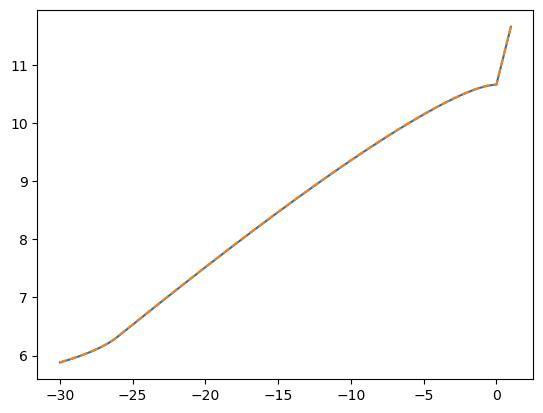

In [95]:
step = -0.01
gwl = np.arange(1, -30, step)
#gwl = np.array([1.])
z = deep_zs[0]
pF = deep_pFs[0]

###
dz = abs(z)
dz[1:] = z[:-1] - z[1:] # profile depths into profile thicknesses

# finer grid for calculating wsto to avoid discontinuity in C (dWsto/dGWL)
z_fine = (np.arange(0, min(z), -0.01) - 0.01).astype(np.float64)
dz_fine = z_fine * 0.0 - step
z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine)
ix = np.zeros(len(z_fine), dtype=np.float64)

for depth in z:
    # below makes sure floating point precision doesnt mess with the ix
    ix += np.where((z_fine < depth) & ~np.isclose(z_fine, depth, atol=1e-9), 1, 0)

pF_fine={}
for key in pF.keys():
    pp = []
    for i in range(len(z_fine)):
        pp.append(pF[key][int(ix[i])])
    pF_fine.update({key: np.array(pp)})

Wsto_deep = [sum(h_to_cellmoist(pF_fine, g - z_mid_fine, dz_fine) * dz_fine)
            + max(0.0,g) for g in gwl]
plt.plot(gwl, Wsto_deep)

###

z = deep_zs
pF = deep_pFs
dz = abs(z)
dz[:,1:] = z[:,:-1] - z[:,1:]
z_min = np.nanmin(z, axis=1)
max_len = int(abs(np.nanmin(z_min)) / abs(step)) + 1
z_fine = np.tile(np.arange(0, step * max_len, step), (z.shape[0], 1)) + step
dz_fine = z_fine * 0.0 - step
z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine, axis=1)
ix = np.full((z_fine.shape), np.nan)
# Expand z along the second axis to match z_fine's shape (broadcasting)
z_expanded = np.expand_dims(z, axis=1)  # Shape: (rows, 1, cols)
z_fine_expanded = np.expand_dims(z_fine, axis=2)  # Shape: (rows, fine_steps, 1)

# Compute mask using broadcasting (row-wise comparison)
mask = (z_fine_expanded < z_expanded) & ~np.isclose(z_fine_expanded, z_expanded, atol=1e-9)

# Sum along the depth dimension to count how many times z_fine falls below z
ix = np.sum(mask, axis=2).astype(int)
ix = np.nan_to_num(ix, nan=0).astype(int)

#plt.plot(ix[0])
pF_fine = {}

for key in pF[0].keys():  # Iterate over each parameter in `pF`
    # Convert pF into an array ensuring consistent shapes
    try:
        pF_array = np.vstack([p[key] for p in pF])  # Ensures (rows, depths) shape
    except ValueError:  # If rows have different lengths, handle it gracefully
        max_depth = max(len(p[key]) for p in pF)  # Find the longest row
        pF_array = np.full((len(pF), max_depth), np.nan)  # Initialize padded array

        # Fill rows with actual values
        for i, p in enumerate(pF):
            pF_array[i, :len(p[key])] = p[key]

    # Ensure `ix` values are within valid range (clip to prevent indexing errors)
    ix_valid = np.clip(ix.astype(int), 0, pF_array.shape[1] - 1)

    # Assign values using vectorized indexing
    pF_fine[key] = np.take_along_axis(pF_array, ix_valid, axis=1)  # Shape: (rows, fine_steps)


Wsto_deep = np.stack([h_to_cellmoist_vectorized(pF_fine, g - z_mid_fine, dz_fine) + max(0.0, g) for g in gwl]).T

plt.plot(gwl, Wsto_deep[0], linestyle='--')


### TESTING TRANSMISSIVITY SEPARATELY

dz [ 1.2  2.6  0.2  1.4 20.6]
Tr0 [262.333728, 261.6420528, 260.9503776, 260.2587024, 259.56702720000004, 258.875352, 258.1836768, 257.4920016, 256.8003264000001, 256.1086512, 255.41697599999998, 254.72530079999999, 254.0336256, 253.34195039999997, 252.6502752, 251.95860000000005, 251.2669248, 250.5752496, 249.8835744, 249.1918992, 248.50022400000003, 247.8085488, 247.1168736, 246.4251984, 245.73352319999995, 245.04184800000002, 244.35017280000002, 243.65849759999998, 242.96682239999998, 242.2751472, 241.583472, 240.89179679999998, 240.2001216, 239.5084464, 238.81677119999998, 238.125096, 237.4334208, 236.7417456, 236.0500704, 235.35839519999996, 234.66671999999997, 233.97504480000003, 233.2833696, 232.59169439999997, 231.90001919999997, 231.20877599999997, 230.5175328, 229.8262896, 229.1350464, 228.44380319999996, 227.75256, 227.0613168, 226.37007359999998, 225.67883039999998, 224.98758719999995, 224.29634399999998, 223.60510079999997, 222.91385759999997, 222.2226144, 221.5313712, 220

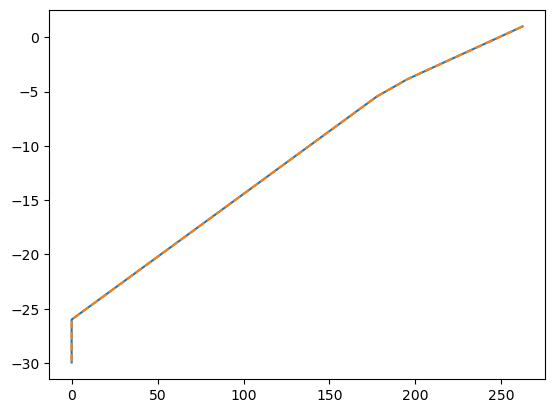

In [96]:
gwl = np.arange(1, -30, -0.05)
#gwl = np.array([-30])
z = deep_zs[0]
dz = abs(z)
dz[1:] = z[:-1] - z[1:] # profile depths into profile thicknesses
Tr0 = [transmissivity(dz, deep_ksats[0], g) * 86400. for g in gwl]  # [m2 d-1]
plt.figure(1)
plt.plot(Tr0, gwl)

#gwl = np.arange(1, -30, -0.05).reshape(1, -1)
z = deep_zs
dz = abs(z)
dz = np.hstack((dz[:, :1], np.diff(dz, axis=1)))

Tr1 = np.stack([transmissivity_vectorized(dz, deep_ksats, g) * 86400. for g in gwl]).T
plt.plot(Tr1[0], gwl, linestyle='--')

In [5]:
ifs = gwl_Wsto(deep_zs, deep_pFs, deep_ksats)
#wtso_to_gwl = ifs['to_gwl']

NameError: name 'gwl_Wsto' is not defined

In [4]:
#ifs = gwl_Wsto(deep_zs[0], deep_pFs[0], deep_ksats[0])
ifs_v = gwl_Wsto_vectorized(deep_zs, deep_pFs, deep_ksats)

## DEMONSTATING HOW LONG SIMULATION WOULD TAKE

In [8]:
to_wsto = np.array(ifs_v['to_wsto'])
vectorized_interp = np.vectorize(lambda f, x: f(x))

In [9]:
test = np.random.uniform(-10, -1, size=len(to_wsto))

for i in range(10):
    result = vectorized_interp(to_wsto, test)

### BELOW IS WITH FOR LOOP

In [5]:
for i in range(len(deep_id_f)):
    if isinstance(deep_pFs[i], dict):  # Ensure it's valid before calling gwl_Wsto
        deep_ifs[i] = gwl_Wsto(deep_zs[i], deep_pFs[i], deep_ksats[i])
        deep_ifs_root[i] = gwl_Wsto(deep_zs[i][:2], 
                                    {k: deep_pFs[i][k][:2] for k in deep_pFs[i]}, 
                                    root=True)

        wtso_to_gwl[i] = deep_ifs[i]['to_gwl']
        gwl_to_wsto[i] = deep_ifs[i]['to_wsto']
        gwl_to_C[i] = deep_ifs[i]['to_C']
        gwl_to_Tr[i] = deep_ifs[i]['to_Tr']
        gwl_to_rootmoist[i] = deep_ifs_root[i]['to_rootmoist']

wtso_to_gwl = wtso_to_gwl.reshape(deep_id.shape)
gwl_to_wsto = gwl_to_wsto.reshape(deep_id.shape)
gwl_to_C = gwl_to_C.reshape(deep_id.shape)
gwl_to_Tr = gwl_to_Tr.reshape(deep_id.shape)
gwl_to_rootmoist = gwl_to_rootmoist.reshape(deep_id.shape)